# Imports

In [1]:
from pyiron import Project
from pyiron_dpd.contrib import SegregationFlow

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
pr = Project('DPD')

In [4]:
pr.inspect_emperical_potentials().find(['Cu', 'Ag']).head(5)

,Config,Filename,Model,Name,Species,Citations
3,"[pair_style eam\n, pair_coeff 1 1 Ag_u3.eam\n,...",[potential_LAMMPS/1986--Foiles-S-M--Ag-Au-Cu-N...,NISTiprpy,1986--Foiles-S-M--Ag-Au-Cu-Ni-Pd-Pt--LAMMPS--ipr1,"[Ag, Au, Cu, Ni, Pd, Pt]",[{'Foiles_1986': {'title': 'Embedded-atom-meth...
21,"[pair_style eam\n, pair_coeff 1 1 agu6.txt\n, ...",[potential_LAMMPS/1989--Adams-J-B--Ag-Au-Cu-Ni...,NISTiprpy,1989--Adams-J-B--Ag-Au-Cu-Ni-Pd-Pt--LAMMPS--ipr1,"[Ag, Au, Cu, Ni, Pd, Pt]",[{'Adams_1989': {'title': 'Self-diffusion and ...
93,"[pair_style eam/alloy\n, pair_coeff * * CuAgAu...",[potential_LAMMPS/2004--Zhou-X-W--Cu-Ag-Au--LA...,NISTiprpy,2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2,"[Cu, Ag, Au]",[{'Zhou_2004': {'title': 'Misfit-energy-increa...
122,"[pair_style eam/alloy\n, pair_coeff * * CuAg.e...",[potential_LAMMPS/2006--Williams-P-L--Cu-Ag--L...,NISTiprpy,2006--Williams-P-L--Cu-Ag--LAMMPS--ipr1,"[Cu, Ag]",[{'Williams_2006': {'title': 'An embedded-atom...
155,"[pair_style meam\n, pair_coeff * * library.mea...",[potential_LAMMPS/2009--Kang-K-H--Cu-Ag--LAMMP...,NISTiprpy,2009--Kang-K-H--Cu-Ag--LAMMPS--ipr1,"[Ag, Cu]",[{'Kang_2009': {'title': 'Atomistic modeling o...


In [5]:
potential = '2006--Williams-P-L--Cu-Ag--LAMMPS--ipr1'

# Grain Boundary Example

We'll calculate the segregation of Ag to a Cu $\Sigma 5 [001]$ GB.

## Create Structure

In [6]:
bulk = pr.create.structure.bulk('Cu', cubic=True)

In [6]:
jbulk = pr.create.job.Lammps('Cu_bulk')
if jbulk.status.initialized:
    jbulk.structure = bulk
    jbulk.calc_minimize(pressure=0)
    jbulk.run()

In [7]:
info = pr.create.structure.aimsgb.info([0,0,1], 7)

In [8]:
info

{5: {'theta': [53.13010235415598, 36.86989764584402],
  'plane': [[[2, -1, 0], [1, 2, 0], [0, 0, 1]],
   [[3, -1, 0], [1, 3, 0], [0, 0, 1]]],
  'rot_matrix': array([[ 0.8, -0.6,  0. ],
         [ 0.6,  0.8,  0. ],
         [ 0. ,  0. ,  1. ]]),
  'csl': [array([[ 2,  1,  0],
          [-1,  2,  0],
          [ 0,  0,  1]]),
   array([[ 3,  1,  0],
          [-1,  3,  0],
          [ 0,  0,  1]])]}}

In [9]:
gb = pr.create.structure.aimsgb.build(
    sigma=5, plane=info[5]['plane'][0][0], axis=[0,0,1], 
    initial_struct=jbulk.get_structure(), 
    uc_a=3, uc_b=3 # number of bulk cell repetitions
)

In [10]:
info = pr.create.structure.aimsgb.info([0,0,1], 7)
gb = pr.create.structure.aimsgb.build(
    sigma=5, plane=info[5]['plane'][0][0], axis=[0,0,1], 
    initial_struct=jbulk.get_structure(), 
    uc_a=3, uc_b=3 # number of bulk cell repetitions
)

In [11]:
gb.cell

Cell([[48.50031350377486, 0.0, 2.9697876845020518e-15], [-4.949646140836753e-16, 8.083385583962476, 4.949646140836753e-16], [0.0, 0.0, 3.6149999308163867]])

In [12]:
jgb = pr.create.job.Lammps('Cu_S5_001_GB')
if jgb.status.initialized:
    jgb.structure = gb
    jgb.calc_minimize(
        pressure=[0, None, None] # relax normal to GB plane only
    )
    jgb.run()

## Setup

In [13]:
seg = SegregationFlow(pr, 'CuAg_S5_001_GB_Segregation')

In [14]:
seg.structure = jgb.get_structure()

Automatically detect likely segregation sites with ACE descriptors.

In [15]:
X = seg.structure.get_scaled_positions()[:, 0]
M = (.25 < X) & (X < .75) # find segregation sites in the center of the box only
locations = seg.suggest_sites(10, mask=M);
locations

/u/system/SLES12/soft/pyiron/dev/anaconda3/lib/python3.8/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)


{'A': 44,
 'B': 104,
 'C': 71,
 'D': 11,
 'E': 17,
 'F': 77,
 'G': 56,
 'H': 116,
 'I': 99,
 'J': 60}

In [16]:
seg.locations = locations
seg.plot_sites()

NGLWidget()

Fix Atoms away from the boundary to keep consistent reference.

In [17]:
seg.structure.add_tag(selective_dynamics=[False, False, False])
seg.structure.selective_dynamics[M] = [True, True, True]

Calculate full segregation space.

In [18]:
seg.max_order = len(seg.locations)

Some computational details.

In [19]:
seg.segregant = 'Ag'
seg.potential = potential
seg.jobtype = 'Lammps'
seg.pressure = [0, None, None]

Don't use super cells.

In [20]:
seg.repeats = [(1,1,1)]

Specify the spatial extent of the defect for normalization.

In [46]:
seg.normalization = np.linalg.det(seg.structure.cell[1:,1:])
seg.normalization_unit = '$\mathrm{\AA}^2$'

## Run

In [15]:
seg = SegregationFlow(pr, 'CuAg_S5_001_GB_Segregation')

In [30]:
seg.run(run_mode='modal')

The job ref_energy was saved and received the ID: 19716399
The job bulk_ref_energy was saved and received the ID: 19716400


Running Jobs:   0%|          | 0/287 [00:00<?, ?it/s]

In [45]:
seg.project.get_jobs_status()

status
finished    290
Name: count, dtype: int64

## Analyze

In [ ]:
seg = SegregationFlow(pr, 'CuAg_S5_001_GB_Segregation')

In [5]:
df = seg.analyze()

Loading and filtering jobs: 0it [00:00, ?it/s]

/u/zora/software/pyiron_base/pyiron_base/jobs/datamining.py:636: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['majority_element', 'minority_element_list', 'sites'], dtype='object')]

  self.pyiron_table._df.to_hdf(


In [7]:
df.columns

Index(['sites', 'original', 'job_id', 'Cu', 'Ag', 'E', 'Ei', 'V', 'N',
       'n_sites', 'repeat', 'coverage', 'mean_displacement',
       'max_displacement', 'sum_displacement', 'E-E0', '[E]N', '[E]N/unit',
       '[Ei]N', '[Ei]N/unit', '[V]N', '[V]N/unit'],
      dtype='object')

In [9]:
df.drop(['mean_displacement', 'max_displacement', 'sum_displacement', 'repeat', 'coverage'], axis='columns').to_csv('gb5_example_dpd.csv')

## Plot DPDs

Loading and filtering jobs: 0it [00:00, ?it/s]

/u/zora/software/pyiron_base/pyiron_base/jobs/datamining.py:636: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['majority_element', 'minority_element_list', 'sites'], dtype='object')]

  self.pyiron_table._df.to_hdf(


Text(0, 0.5, 'Formation Energy [eV]')

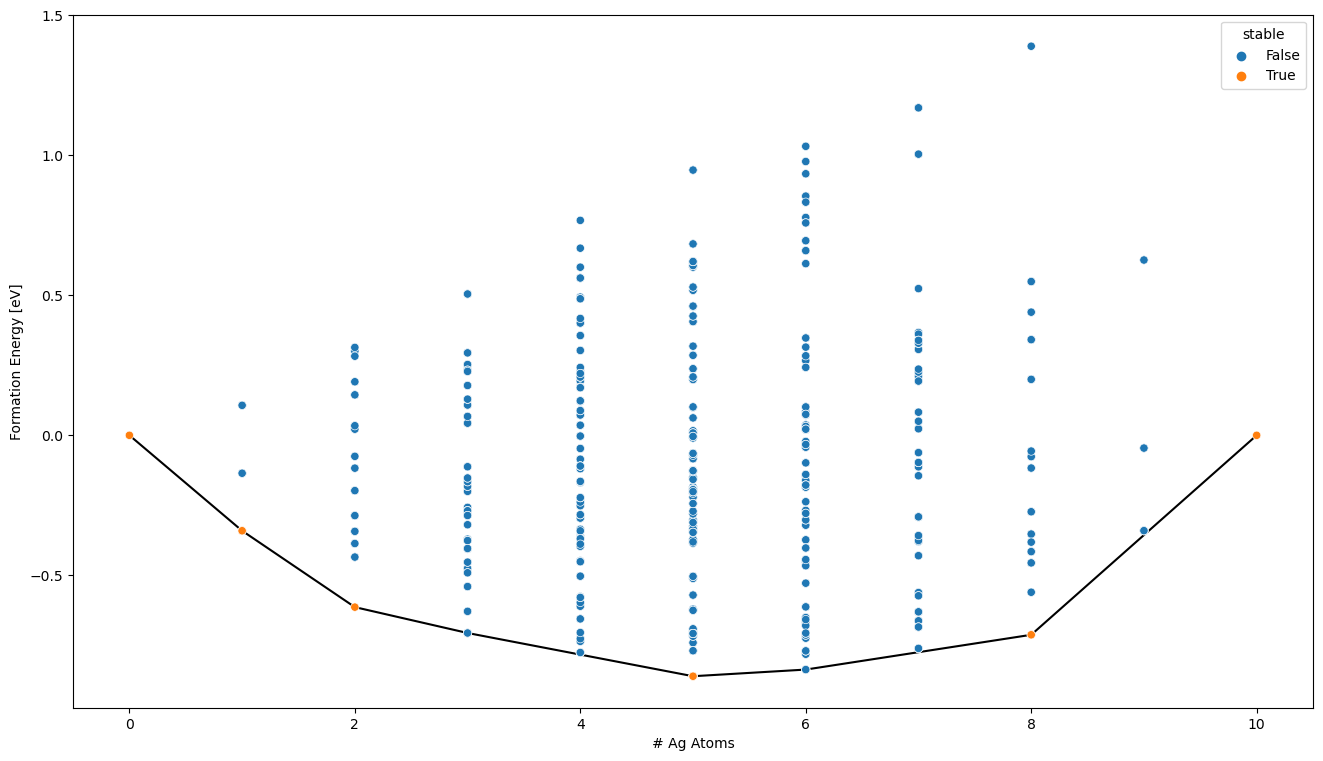

In [33]:
seg.plot_excess_energies();
plt.xlabel('# Ag Atoms')
plt.ylabel('Formation Energy [eV]')

Loading and filtering jobs: 0it [00:00, ?it/s]

/u/zora/software/pyiron_base/pyiron_base/jobs/datamining.py:636: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['majority_element', 'minority_element_list', 'sites'], dtype='object')]

  self.pyiron_table._df.to_hdf(


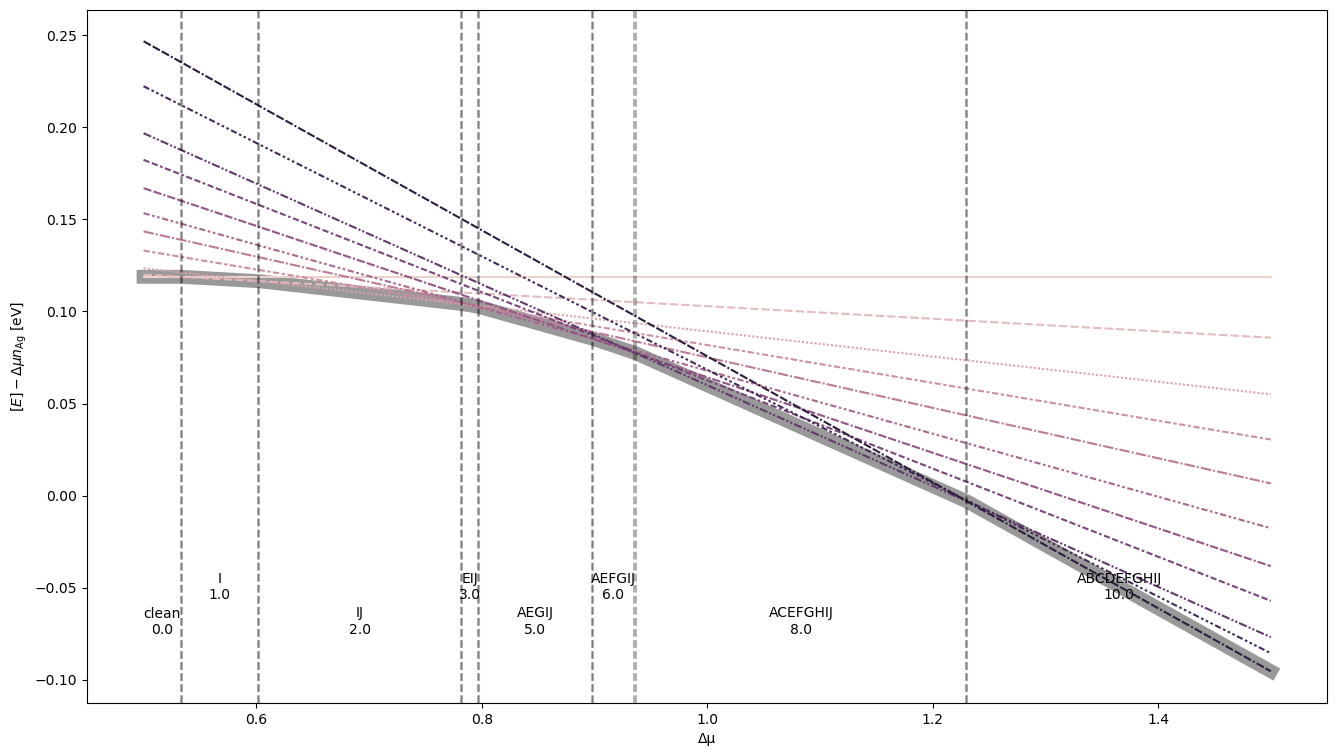

In [22]:
seg.plot_defect_phase_diagram(chem_pot=np.linspace(0.5,1.5,1000))
plt.ylabel('$[E] - \Delta\mu n_\mathrm{Ag}$ [eV]');

Loading and filtering jobs: 0it [00:00, ?it/s]

/u/zora/software/pyiron_base/pyiron_base/jobs/datamining.py:636: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['majority_element', 'minority_element_list', 'sites'], dtype='object')]

  self.pyiron_table._df.to_hdf(


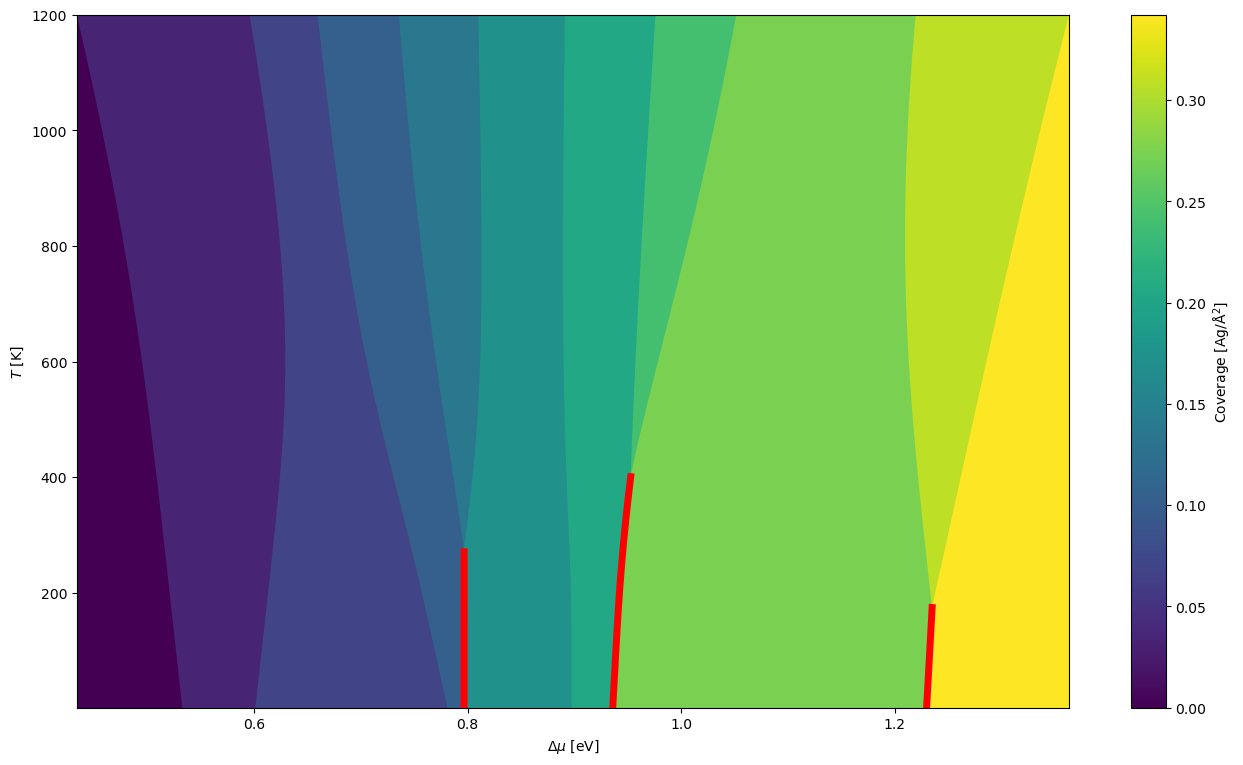

In [49]:
seg.plot_defect_phase_diagram_free(temperatures=np.linspace(1, 1200, 250));